In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df=pd.read_csv("/kaggle/input/th-gaussion/Gia SMP va SMPcap 2021(Gi th trng SMP).csv",encoding='latin-1')


In [3]:
feats= ['6']

In [4]:
df[feats].head()

,6
0,964.4
1,1019.7
2,988.4
3,1002.0
4,1061.5


In [5]:
df.info

<bound method DataFrame.info of            Ngày       1       2       3       4       5       6       7  \
0      1/1/2021   964.4   964.4   964.4   964.4   964.4   964.4   964.4   
1      1/2/2021  1019.7  1019.7  1019.7  1019.7  1019.7  1019.7  1019.7   
2      1/3/2021   988.4   988.4   988.4   988.4   988.4   988.4   988.4   
3      1/4/2021  1002.0  1002.0  1002.0  1002.0  1002.0  1002.0  1002.0   
4      1/5/2021  1061.5  1061.5  1061.5  1061.5  1061.5  1061.5  1061.5   
..          ...     ...     ...     ...     ...     ...     ...     ...   
360  27/12/2021  1002.0  1002.0  1002.0  1002.0  1002.0  1002.0  1002.0   
361  28/12/2021  1002.0  1002.0  1002.0  1002.0  1002.0  1002.0  1002.0   
362  29/12/2021  1061.5  1061.5  1061.5  1061.5  1061.5  1061.5  1061.5   
363  30/12/2021  1022.6  1022.6  1022.6  1022.6  1022.6  1022.6  1022.6   
364  31/12/2021  1022.6  1022.6  1022.6  1022.6  1022.6  1022.6  1022.6   

          8       9  ...      39      40      41      42      43   

In [6]:
# Chuyển đổi cột '6' thành mảng 2D
X = df['5'].values.reshape(-1, 1)

# Áp dụng PowerTransformer
transformer = PowerTransformer()
X_transformed = transformer.fit_transform(X)

In [7]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)

#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

In [8]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columSSns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [9]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 


[200]	valid_0's multi_logloss: 0.000151726
[400]	valid_0's multi_logloss: 0.000151726
[200]	valid_0's multi_logloss: 0.000153686
[400]	valid_0's multi_logloss: 0.000153686
[200]	valid_0's multi_logloss: 0.000154034
[400]	valid_0's multi_logloss: 0.000154034
[600]	valid_0's multi_logloss: 0.000154034
[200]	valid_0's multi_logloss: 0.000156754
[400]	valid_0's multi_logloss: 0.000156754
[200]	valid_0's multi_logloss: 0.000153261
[400]	valid_0's multi_logloss: 0.000153261
[200]	valid_0's multi_logloss: 0.00015524
[400]	valid_0's multi_logloss: 0.00015524
[200]	valid_0's multi_logloss: 0.000155472
[400]	valid_0's multi_logloss: 0.000155472
[200]	valid_0's multi_logloss: 9.92419e-06
[400]	valid_0's multi_logloss: 9.8222e-06
[600]	valid_0's multi_logloss: 9.75475e-06
[800]	valid_0's multi_logloss: 9.70667e-06
[1000]	valid_0's multi_logloss: 9.67072e-06
[1200]	valid_0's multi_logloss: 9.64285e-06
[1400]	valid_0's multi_logloss: 9.62062e-06
[1600]	valid_0's multi_logloss: 9.60248e-06
[1800]	val

In [10]:
col_index = 5  
r_t = np.log(df.iloc[:, col_index] / df.iloc[:, col_index].shift(1)).values

In [11]:
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

array([ 0.00016098,  0.0557576 , -0.03117627,  0.01366581,  0.057685  ])

In [12]:
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.348025
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


<Figure size 800x600 with 0 Axes>

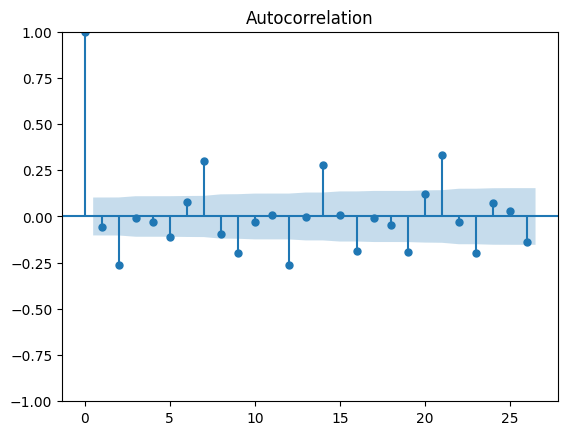

In [13]:
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)

<Figure size 800x600 with 0 Axes>

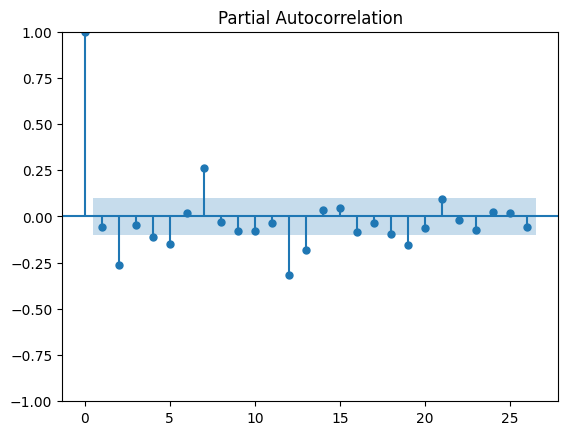

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t)

In [15]:
model_arima = ARIMA(r_t, order=(2, 0, 2))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 563.754
Date:                Tue, 07 May 2024   AIC                          -1115.508
Time:                        03:44:04   BIC                          -1092.108
Sample:                             0   HQIC                         -1106.208
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.125e-05      0.001     -0.029      0.977      -0.001       0.001
ar.L1         -0.0138      0.080     -0.173      0.862      -0.170       0.143
ar.L2          0.4604      0.074      6.251      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
